# DGIdb disease categorization of citations analysis

This analysis investigates the distribution of major disease categories across three biomedical data sources: DGIdb, Pharos, and OpenTargets. Using a keyword-based mapping derived from MeSH terms, each publication is categorized into one or more disease areas, such as cancer, psychiatric disorders, and infectious diseases. The analysis identifies category frequencies and visualizes the distributions as a grouped histogram, enabling a comparative assessment of disease focus across the three sources.

## Data preparation
For each resource (DGIdb, Pharos, OpenTargets):
1. Went to each of the resource publications in PubMed
    1. DGIdb 1, 2, 3, 4, 5
    2. Pharos (4 publications from https://pharos.nih.gov/about)
    3. OpenTargets (4 publications from https://platform-docs.opentargets.org/citation)
3. Added all citing records to a resource-specific NCBI collection
    1. [DGIdb](https://pubmed.ncbi.nlm.nih.gov/collections/64886717/?sort=pubdate)
    2. [Pharos](https://pubmed.ncbi.nlm.nih.gov/collections/64930467/?sort=pubdate)
    3. [OpenTargets](https://pubmed.ncbi.nlm.nih.gov/collections/64930936/?sort=pubdate)
4. Exported citation table .csv and abstracts .txt files to `data/` directory

In [1]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define the major disease category mapping
disease_category_map = {
        "cancer": ["cancer", "carcinoma", "tumor", "neoplasm", "sarcoma", "melanoma", "leukemia", "lymphoma", "oncology", "metastasis", "malignancy", "adenocarcinoma", "glioblastoma", "myeloma", "retinoblastoma", "teratoma", "choriocarcinoma", "mesothelioma", "neuroblastoma"],
        "cardiovascular diseases": ["cardiovascular", "heart", "stroke", "artery", "myocardial", "hypertension", "atherosclerosis", "arrhythmia", "ventricular", "coronary", "angina", "thrombosis", "ischemia", "cardiac", "vascular", "endocarditis", "pericarditis", "valvular", "arteritis", "cardiomyopathy", "arteriosclerosis"],
        "metabolic disorders": ["diabetes", "obesity", "metabolism", "metabolic", "hyperglycemia", "insulin", "lipid", "dyslipidemia", "cholesterol", "glucose", "hba1c", "adipose", "triglyceride", "endocrine", "glycemic", "hyperlipidemia", "hypoglycemia", "phenylketonuria", "acidosis", "hyperuricemia", "metabolic syndrome"],
        "kidney diseases": ["kidney", "renal", "nephropathy", "nephritis", "glomerular", "uremia", "dialysis", "proteinuria", "hematuria", "tubulointerstitial", "glomerulonephritis", "nephrotoxicity", "polycystic", "renal failure", "hydronephrosis", "nephrolithiasis", "pyelonephritis"],
        "neurological disorders": ["neurological", "brain", "neurodegenerative", "alzheimer", "parkinson", "epilepsy", "multiple sclerosis", "dementia", "migraine", "neuroinflammation", "cognitive", "seizure", "huntington", "amyotrophic", "neural", "spinal", "encephalitis", "neuropathy", "meningitis", "myasthenia", "gliosis", "cerebrovascular"],
        "autoimmune diseases": ["autoimmune", "arthritis", "lupus", "sclerosis", "psoriasis", "autoantibodies", "immunological", "crohn's", "celiac", "rheumatoid", "sjogren", "inflammatory", "vasculitis", "connective tissue", "myositis", "ankylosing spondylitis", "autoimmune hepatitis", "dermatomyositis", "spondyloarthritis"],
        "infectious diseases": ["infection", "infectious", "virus", "bacteria", "covid", "sars-cov-2", "coronavirus", "hepatitis", "hiv", "influenza", "tuberculosis", "sepsis", "pathogen", "microbial", "antiviral", "antibacterial", "antimicrobial", "fungal", "pneumonia", "malaria", "dengue", "zika", "ebola", "leptospirosis", "typhoid", "parasitic", "herpes", "measles", "rubella"],
        "respiratory diseases": ["respiratory", "lung", "asthma", "copd", "bronchitis", "pulmonary", "emphysema", "fibrosis", "pleural", "ventilation", "alveolar", "bronchial", "tracheal", "hypoxia", "oxygenation", "bronchiectasis", "pneumonitis", "cystic fibrosis", "rhinitis", "sinusitis"],
        "psychiatric disorders": ["psychiatric", "mental", "depression", "anxiety", "ptsd", "schizophrenia", "bipolar", "autism", "adhd", "psychosis", "ocd", "personality", "behavioral", "suicidal", "mood", "stress", "eating disorder", "dissociative disorder", "addiction", "phobia", "neurosis"]
}

def analyze_citations_with_abstracts(citations_filepath, abstracts_filepath):
    """
    Analyze the provided citations CSV file and abstracts text file.

    Args:
        citations_filepath (str): Path to the CSV file containing citation data.
        abstracts_filepath (str): Path to the text file containing abstracts.

    Returns:
        pd.DataFrame: A DataFrame containing the merged and processed data.
    """
    # Load the citations CSV file
    citations_df = pd.read_csv(citations_filepath)

    # Load the abstracts text file
    with open(abstracts_filepath, 'r') as file:
        abstracts = file.read()

    # Process abstracts
    try:
        return process_abstracts(citations_df, abstracts)
    except Exception as e:
        raise ValueError(f"Error processing files: {e}")

def process_abstracts(citations_df, abstracts):
    """
    Process the abstracts and merge with citation data.

    Args:
        citations_df (pd.DataFrame): DataFrame containing citation data.
        abstracts (str): Full text of abstracts.

    Returns:
        pd.DataFrame: A DataFrame containing merged citation and abstract data with disease categories assigned.
    """
    # Extract abstracts and their PMIDs
    abstracts_with_pmids = re.findall(r'^\d+\.\s.+?\n\n.*?(?=\n\d+\.\s|\Z)', abstracts, re.DOTALL | re.MULTILINE)
    abstracts_data = []
    for abstract in abstracts_with_pmids:
        match = re.search(r'PMID:\s(\d+)', abstract)
        if match:
            pmid = match.group(1)
            abstracts_data.append({'PMID': int(pmid), 'Abstract': abstract})

    # Convert the parsed abstracts into a DataFrame
    abstracts_df = pd.DataFrame(abstracts_data)

    # Merge citations with abstracts
    merged_data = pd.merge(citations_df, abstracts_df, on='PMID', how='left')

    # Function to assign one or more major categories to an abstract based on keywords
    def assign_major_categories(abstract, category_map):
        """
        Assign one or more major disease categories to an abstract based on keywords.

        Args:
            abstract (str): Abstract text to be categorized.
            category_map (dict): Mapping of disease categories to keywords.

        Returns:
            list: A list of assigned disease categories or ["other"] if no matches are found.
        """
        categories = [category for category, keywords in category_map.items() if any(keyword in abstract.lower() for keyword in keywords)]
        return categories if categories else ["other"]

    # Assign categories to each abstract
    merged_data["Major Disease Categories"] = merged_data["Abstract"].apply(
        lambda x: assign_major_categories(x, disease_category_map)
    )

    # Flatten the categories for frequency calculation
    all_categories = [cat for cats in merged_data["Major Disease Categories"] for cat in cats]
    category_distribution = pd.DataFrame(Counter(all_categories).items(), columns=["Major Disease Category", "Frequency"])
    category_distribution["Percentage"] = (category_distribution["Frequency"] / len(merged_data)) * 100

    return category_distribution.sort_values(by="Frequency", ascending=False).reset_index(drop=True)


In [13]:
def plot_disease_category_distribution(dgidb_results, pharos_results, opentargets_results):
    """
    Plot a grouped histogram showing disease category distributions across DGIdb, Pharos, and OpenTargets.

    Args:
        dgidb_results (pd.DataFrame): DataFrame containing DGIdb disease category results.
        pharos_results (pd.DataFrame): DataFrame containing Pharos disease category results.
        opentargets_results (pd.DataFrame): DataFrame containing OpenTargets disease category results.
    """
    # Align categories based on DGIdb frequency ranking, with "other" last
    categories_order = [
        "cancer", "psychiatric disorders", "infectious diseases",
        "neurological disorders", "metabolic disorders", "autoimmune diseases",
        "cardiovascular diseases", "respiratory diseases", "kidney diseases", "other"
    ]

    # Reorder the dataframes
    dgidb_results_ordered = dgidb_results.set_index("Major Disease Category").reindex(categories_order).reset_index()
    pharos_results_ordered = pharos_results.set_index("Major Disease Category").reindex(categories_order).reset_index()
    opentargets_results_ordered = opentargets_results.set_index("Major Disease Category").reindex(categories_order).reset_index()

    # Extract data for plotting
    x = np.arange(len(categories_order))  # Label locations
    width = 0.25  # Width of the bars

    # Plot the data
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.bar(x - width, dgidb_results_ordered["Percentage"], width, label="DGIdb", color="purple")
    ax.bar(x, pharos_results_ordered["Percentage"], width, label="Pharos", color="gray")
    ax.bar(x + width, opentargets_results_ordered["Percentage"], width, label="OpenTargets", color="lightblue")

    # Customize the plot
    ax.set_xlabel("Major Disease Category")
    ax.set_ylabel("Percentage of Publications Referencing Disease Category")
    ax.set_title("Disease Category Distribution Across Major Drug-Target Aggregation Knowledgebase")
    ax.set_xticks(x)
    ax.set_xticklabels(categories_order, rotation=45, ha="right")
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

In [14]:
dgidb_results = analyze_citations_with_abstracts('data/dgidb-citations.csv', 'data/dgidb-citation-abstracts.txt')
pharos_results = analyze_citations_with_abstracts('data/pharos-citations.csv', 'data/pharos-citation-abstracts.txt')
opentargets_results = analyze_citations_with_abstracts('data/opentargets-citations.csv', 'data/opentargets-citation-abstracts.txt')

In [16]:
dgidb_results

,Major Disease Category,Frequency,Percentage
0,cancer,672,52.830189
1,psychiatric disorders,379,29.795597
2,infectious diseases,329,25.864780
3,neurological disorders,262,20.597484
4,metabolic disorders,214,16.823899
5,autoimmune diseases,199,15.644654
6,cardiovascular diseases,189,14.858491
7,respiratory diseases,176,13.836478
8,other,87,6.839623
9,kidney diseases,51,4.009434


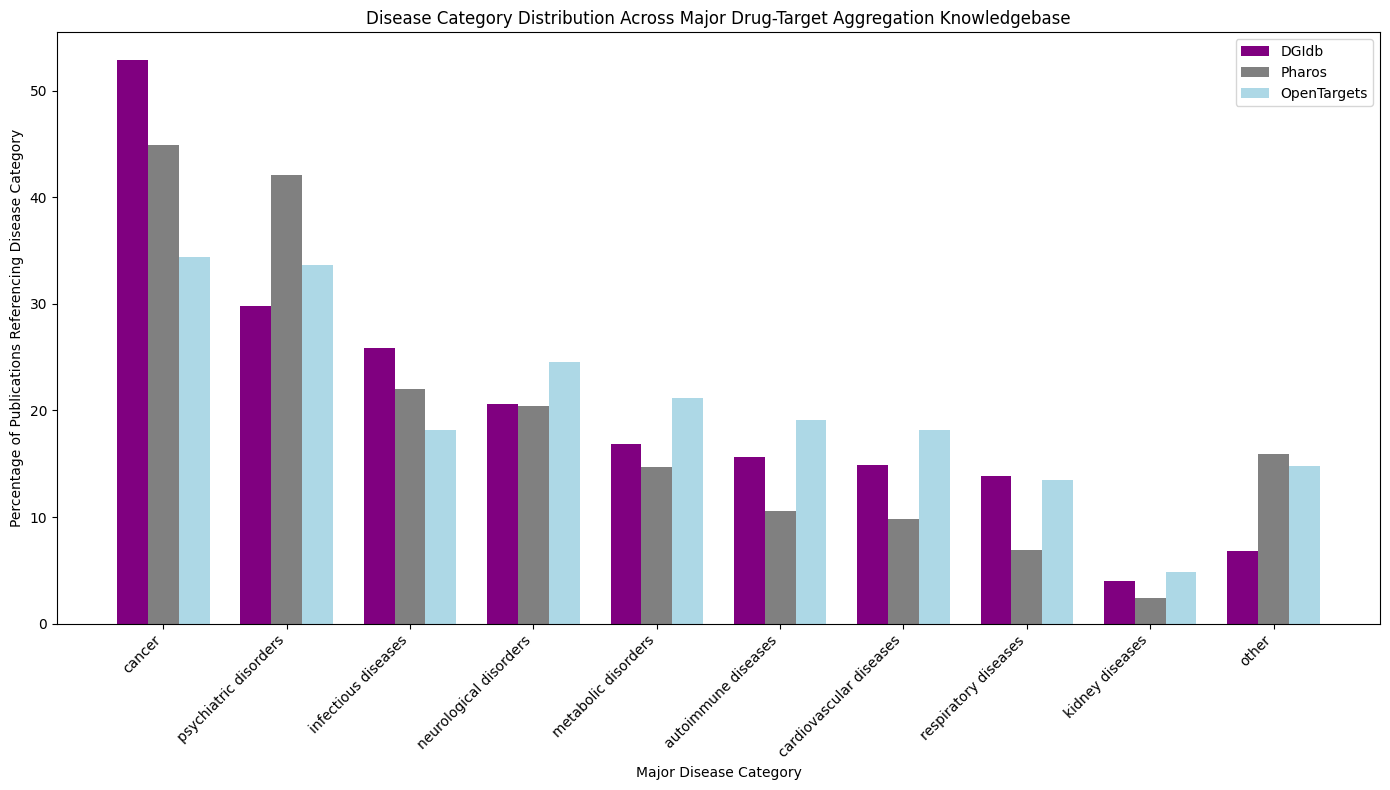

In [15]:
plot_disease_category_distribution(dgidb_results, pharos_results, opentargets_results)